# Download Data 

In [40]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Flicker8k_Dataset/1001773457_577c3a7d70.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Flicker8k_Dataset/1002674143_1b742ab4b8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/Flicker8k_Dataset/._1002674143_1b742ab4b8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Flicker8k_Dataset/1003163366_44323f5815.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/Flicker8k_Dataset/._1003163366_44323f5815.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Flicker8k_Dataset/1007129816_e794419615.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/Flicker8k_Dataset/._1007129816_e794419615.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Flicker

In [41]:
#Mount Drive If Needed

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries and Tools

In [43]:
import tensorflow as tf


import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

import warnings
warnings.filterwarnings('ignore')

0it [00:00, ?it/s]

# Cleaning Captions

In [ ]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"
SEQ_LENGTH = 25


In [ ]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = caption.strip() 
                
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

Number of training samples:  6114
Number of validation samples:  1529


In [ ]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text


# get all images with their captions
def img_capt(filename):
  file = load_fp(filename)
  captions = file.split('n')
  descriptions ={}
  for caption in captions[:-1]:
    print(caption.split('t'))
    img, caption = caption.split('t')
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [ caption ]
    else:
      descriptions[img[:-2]].append(caption)

  return descriptions


#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers

def txt_clean(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
           img_caption.replace("-"," ")
           descp = img_caption.split()
          #uppercase to lowercase
           descp = [wrd.lower() for wrd in descp]
          #remove punctuation from each token
           descp = [wrd.translate(table) for wrd in descp]
          #remove hanging 's and a
           descp = [wrd for wrd in descp if(len(wrd)>1)]
          #remove words containing numbers with them
           descp = [wrd for wrd in descp if(wrd.isalpha())]
          #converting back to string
           img_caption = ' '.join(descp)
           captions[img][i]= img_caption
  return captions

def start_end(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
           img_caption = '<start> ' + img_caption + ' <end>'
           captions[img][i]= img_caption
  return captions


def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  for key in descriptions.keys():
       [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + 't' + desc )

  data = "n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()


In [ ]:
print("Length of descriptions =" ,len(captions_mapping))
#cleaning the descriptions
clean_descriptions = txt_clean(captions_mapping)
#to build vocabulary
clean_descriptions = start_end(clean_descriptions)
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

train_data, valid_data = train_val_split(clean_descriptions)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Length of descriptions = 7643
Length of vocabulary =  8507
Number of training samples:  6114
Number of validation samples:  1529


In [ ]:
save_descriptions(clean_descriptions, "descriptions_clean.txt")

In [ ]:
#Run the following if you want to save

#dump(train_data, open("/content/drive/MyDrive/train_data.p","wb"))
#dump(valid_data, open("/content/drive/MyDrive/valid_data.p","wb"))

# Feature extraction if not extracted already

If not extracted:

In [ ]:
model = Xception( include_top=False,pooling='avg')

In [48]:
def extract_features(directory):
  model = Xception( include_top=False, pooling='avg' )
  features = {}
  for pic in tqdm(os.listdir(IMAGES_PATH)):
           file = IMAGES_PATH + "/" + pic
           image = Image.open(file)
           image = image.resize((299,299))
           image = np.expand_dims(image, axis=0)
          #image = preprocess_input(image)
           image = image/127.5
           image = image - 1.0
           feature = model.predict(image)
           features[pic] = feature
  return features

#2048 feature vector
features = extract_features('/content/Flicker8k_Dataset')
dump(features, open("/content/features.p","wb"))
#to directly load the features from the pickle file.
features = load(open("/content/features.p","rb"))

# Loading Saved Features

Run this only if already saved

In [10]:
features = load(open("/data/features.p","rb"))
type(features)

dict

# Building Vocabulary

In [ ]:
train_descriptions = train_data
descriptions = captions_mapping
Vocab_size = 10000


#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    for d in descriptions[key]:
      all_desc.append(d) 
  return all_desc
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
   desc_list = dict_to_list(descriptions)
   tokenizer = Tokenizer()
   tokenizer.fit_on_texts(desc_list)
   return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(descriptions)
dump(tokenizer, open('/content/drive/MyDrive/tokenizer1.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
Vocab_size #The size of our vocabulary is 7577 words.
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
   desc_list = dict_to_list(descriptions)
   return max(len(d.split()) for d in desc_list)
Max_length = max_length(descriptions)
Max_length #Max_length of description is 32

26

# Build, Train and Evaluate Model

### Data Generator

In [ ]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
          #retrieve photo features
           feature = features[key[18:]][0]
           inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
           yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
  x_1, x_2, y = list(), list(), list()
  # move through each description for the image
  for desc in desc_list:
      # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
      # divide one sequence into various X,y pairs
  for i in range(1, len(seq)):
          # divide into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
     
      in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=Max_length)[0]
          # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
      x_1.append(feature)
      x_2.append(in_seq)
      y.append(out_seq)

  return np.array(x_1), np.array(x_2), np.array(y)

#To check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape


((12, 2048), (12, 26), (12, 8506))

### Build and Train Model

In [ ]:
from tensorflow.keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
  # features from the CNN model compressed from 2048 to 256 nodes
   inputs1 = Input(shape=(2048,))
   fe1 = Dropout(0.5)(inputs1)
   fe2 = Dense(256, activation='relu')(fe1)
  # LSTM sequence model
   inputs2 = Input(shape=(max_length,))
   se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
   se2 = Dropout(0.5)(se1)
   se3 = LSTM(256)(se2)
  # Merging both models
   decoder1 = add([fe2, se3])
   decoder2 = Dense(256, activation='relu')(decoder1)
   outputs = Dense(vocab_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
   model = Model(inputs=[inputs1, inputs2], outputs=outputs)
   model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  # summarize model
   print(model.summary())
   plot_model(model, to_file='model.png', show_shapes=True)
   return model

In [ ]:
# train our model
#print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', Max_length)
model = define_model(vocab_size, Max_length)
epochs = 20
steps = len(train_descriptions)
# creating a directory named models to save our models
#os.mkdir("models")
loss = []
for i in range(epochs):
   train_generator = data_generator(train_descriptions, features, tokenizer, Max_length)
   valid_generator = data_generator(valid_data, features, tokenizer, Max_length)

   history = model.fit(train_generator,epochs=1, batch_size = 500, steps_per_epoch= steps, verbose=1)
   loss.append(history.history['loss'])
   model.save("model_" + str(i) + ".h5")

Descriptions: train= 6114
Photos: train= 8091
Vocabulary Size: 8506
Description Length:  26
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 input_41 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 26, 256)      2177536     ['input_42[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 2048)         0           ['input_41[0][0]']               

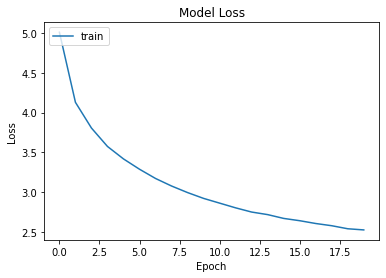

In [8]:

from matplotlib import pyplot as plt

plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## BLeU Score evaluation on Test Data

In [36]:
from nltk.translate.bleu_score import corpus_bleu,SmoothingFunction
smoothie = SmoothingFunction().method6

def calculate_bleu(key,reference,pred):

  description_list = reference[key]
  desc = []
  for sentence in description_list:
    sentence = sentence.replace("<start> ","")
    sentence = sentence.replace(" <end>","")
    desc.append(sentence.split())
  pred = pred.split()
  score = corpus_bleu([desc], [pred], smoothing_function=None)
  return score

from tensorflow.python.eager.context import in_eager_mode
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from pickle import load
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences


def extract_features(filename, model):

  image = Image.open(filename)
  image = image.resize((299,299))
  image = np.expand_dims(image, axis=0)
         
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)

  return feature


def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
        return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
       sequence = tokenizer.texts_to_sequences([in_text])[0]
       sequence = pad_sequences([sequence], maxlen=max_length)
      
       pred = model.predict([photo,sequence], verbose=0)
       pred = np.argmax(pred)
       word = word_for_id(pred, tokenizer)
       if word is ".":
           break
       in_text += ' ' + word
       if word == 'end':
           break
  
  decoded_caption = in_text.replace("start ", "")
  decoded_caption = decoded_caption.replace(" end", "").strip()
  return decoded_caption

def predict_bleu(img_path,data):
  
    photo = extract_features(img_path, xception_model)
    photo = photo.reshape(1,2048)
    description = generate_desc(model, tokenizer,photo, max_length)
    return calculate_bleu(img_path,data,description)



In [ ]:
max_length = 26
xception_model = Xception(include_top=False,pooling='avg')

scores = []
pbar = tqdm(valid_data.keys())
for key in pbar:
  scores.append(predict_bleu(key,valid_data))
  pbar.set_postfix({'BLEU ': np.average(scores)})

BLeU = np.average(scores)
print("Overall Corpus BleU score on the Validation Data: ",BLeU)


### BLeU score for saved model_19 (Make sure the path is correct)



In [39]:
'''
tokenizer_path = "/content/drive/MyDrive/tokenizer1.p"
model_path = '/content/drive/MyDrive/models/model1_19.h5'
valid_data_path = "/content/drive/MyDrive/valid_data.p"

#Load Saved Model, Tokenizer, Xception Model and Valid_data

max_length = 26
tokenizer = load(open(tokenizer_path,"rb"))
model = load_model(model_path)
xception_model = Xception(include_top=False,pooling='avg')
valid_data = load(open(valid_data_path,"rb"))

scores = []
pbar = tqdm(valid_data.keys())
for key in pbar:
  scores.append(predict_bleu(key,valid_data))
  pbar.set_postfix({'BLEU ': np.average(scores)})

BLeU = np.average(scores)
print("Overall Corpus BleU score on the Validation Data: ",BLeU) 
'''

  0%|          | 0/1529 [00:00<?, ?it/s]

Overall Corpus BleU score on the Validation Data:  0.573416065404553


### BLeU Score for saved model_29 (Make sure the path is correct)

In [21]:
#Change the path

#tokenizer_path = "/content/drive/MyDrive/Image Captioning/tokenizer.p"
#model_path = '/content/drive/MyDrive/Image Captioning/model_29.h5'
#valid_data_path = "/content/drive/MyDrive/Image Captioning/valid_data.p"

tokenizer_path = "/data/tokenizer.p"
model_path = '/Models/model_29.h5'
valid_data_path = "/data/valid_data.p"


max_length = 26
tokenizer = load(open(tokenizer_path,"rb"))
model = load_model(model_path)
xception_model = Xception(include_top=False,pooling='avg')
valid_data = load(open(valid_data_path,"rb"))

scores = []
pbar = tqdm(valid_data.keys())
for key in pbar:
  scores.append(predict_bleu(key,valid_data))
  pbar.set_postfix({'BLEU ': np.average(scores)})

BLeU = np.average(scores)
print("Overall Corpus BleU score on the Validation Data: ",BLeU)


  0%|          | 0/1529 [00:00<?, ?it/s]

Overall Corpus BleU score on the Validation Data:  0.5759065182588817


# DEMO:

Load Saved Tokenizer, Xception Model and the trained Custom Model.

In [44]:
from tensorflow.python.eager.context import in_eager_mode
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from pickle import load
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences


def extract_features(filename, model):


  image = Image.open(filename)
  image = image.resize((299,299))
  image = np.expand_dims(image, axis=0)

  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)

  return feature


def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
        return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
       sequence = tokenizer.texts_to_sequences([in_text])[0]
       sequence = pad_sequences([sequence], maxlen=max_length)
      
       pred = model.predict([photo,sequence], verbose=0)
       pred = np.argmax(pred)
       word = word_for_id(pred, tokenizer)
       if word is ".":
           break
       in_text += ' ' + word
       if word == 'end':
           break
  
  decoded_caption = in_text.replace("start ", "")
  decoded_caption = decoded_caption.replace(" end", "").strip()
  return decoded_caption


In [45]:
#Enter path

tokenizer_path = "/data/tokenizer.p"
model_path = '/Models/model_29.h5'
valid_data_path = "/data/valid_data.p"

max_length = 26
tokenizer = load(open(tokenizer_path,"rb"))
model = load_model(model_path)
xception_model = Xception(include_top=False,pooling='avg')
valid_data = load(open(valid_data_path,"rb"))

In [46]:
def predict_caption(img_path):
    photo = extract_features(img_path, xception_model)
    photo = photo.reshape(1,2048)
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer,photo, max_length)
    print(description)
    plt.imshow(img)

In [26]:
valid_data.keys()

dict_keys(['Flicker8k_Dataset/3621741935_54d243f25f.jpg', 'Flicker8k_Dataset/2257099774_37d0d3aa9a.jpg', 'Flicker8k_Dataset/1557838421_a33f2a4911.jpg', 'Flicker8k_Dataset/3100251515_c68027cc22.jpg', 'Flicker8k_Dataset/2171576939_d1e72daab2.jpg', 'Flicker8k_Dataset/2275029674_6d4891c20e.jpg', 'Flicker8k_Dataset/1107471216_4336c9b328.jpg', 'Flicker8k_Dataset/3693297007_94512e861e.jpg', 'Flicker8k_Dataset/2506892928_7e79bec613.jpg', 'Flicker8k_Dataset/534669139_1a4f8ab9d5.jpg', 'Flicker8k_Dataset/463786229_b54c9a3436.jpg', 'Flicker8k_Dataset/3158680604_c1f99b3946.jpg', 'Flicker8k_Dataset/3498354674_b636c7992f.jpg', 'Flicker8k_Dataset/2635908229_b9fc90d3fb.jpg', 'Flicker8k_Dataset/95734035_84732a92c1.jpg', 'Flicker8k_Dataset/411863595_d77156687e.jpg', 'Flicker8k_Dataset/2305437797_e6c3460190.jpg', 'Flicker8k_Dataset/1904112245_549e47c8aa.jpg', 'Flicker8k_Dataset/2271468944_3264d29208.jpg', 'Flicker8k_Dataset/2828583747_8cfb7217af.jpg', 'Flicker8k_Dataset/483039719_75181b2726.jpg', 'Flicker

#### Enter image path

the dog is running through the water


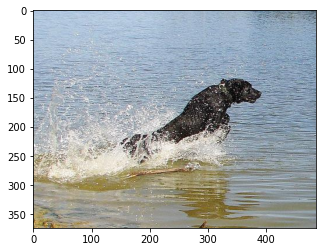

In [47]:
img_path = 'Flicker8k_Dataset/1731546544_9fbf14617b.jpg'
predict_caption(img_path)

the boy is running along the ground


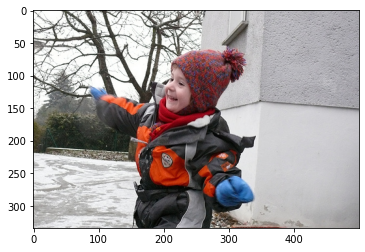

In [48]:
predict_caption("Flicker8k_Dataset/2171576939_d1e72daab2.jpg")